In [1]:
%use lib-ext(0.11.0-398)

@file:DependsOn("com.brainvault:utils:0.1.0")
import com.brainvault.utils.units.*
import com.brainvault.utils.mechanics.*
import com.brainvault.utils.constants.*
import com.brainvault.utils.hardware.belts.*

# Base info

In [2]:
import kotlin.time.Duration

val maxFeed = 1500.mmPerMinute

val ballBearingSpindlePitch = 5.mm.length
val beltRatio = GearRatio(.25)

val linearAcceleration = 0.5.mps2
val timeToGetUpToSpeed = (maxFeed.inMetersPerSec / linearAcceleration.inMetersPerSec2).seconds

val omegaScrew = maxFeed.toAngularForScrew(ballBearingSpindlePitch)
val omegaMotor = omegaScrew / beltRatio
val alphaMotor = omegaMotor / timeToGetUpToSpeed

val ramMass = 500.kg
// Estimated mass of the milling table including workpiece
val tableMass = 300.kg

val ballscrewEfficiency = 0.90

# Z-axis

## Inertia

In [3]:
// Inertia van de klemkoppeling tussen motor en verlengas
// Opgemeten in SolidWorks
//val couplingInertia = 286466.5.gMm2
// https://www.maedler.nl/Article/61588022
val couplingInertia = hollowCylinderInertia(.6.kg, 55.mm.diameter, 22.mm.diameter)
// https://www.maedler.nl/Article/60156619
val coupling2Inertia = hollowCylinderInertia(500.g, 66.mm.diameter, 22.mm.diameter)
// https://www.maedler.nl/Article/60155619
val coupling3Inertia = hollowCylinderInertia(270.g, 56.mm.diameter, 22.mm.diameter)
// Inertia van de verlengas
// Opgemeten in SolidWorks
val axleInertia = 22770.75.gMm2
// Inertia van de z=18 poelie
// Opgemeten in SolidWorks
val z18pulleyInertia = 58615.72.gMm2

// Inertia van de z=72 poelie
val z72pulleyInertia = hollowCylinderInertia(3238.g, 190.mm.diameter, 22.mm.diameter)
// Inertia van de kogelomloopspindel
val spindleInertia = cylinderInertia(6.kg, 40.mm.diameter)
// Inertia van de ram
// 500 kg is mijn eigen schatting
val ramInertia = linearInertia(ramMass, ballBearingSpindlePitch)


val totalZAxisInertia = totalInertia(
//    couplingInertia to 1.0.ratio,
//    axleInertia to 1.0.ratio,
    z18pulleyInertia to 1.0.ratio,
    z72pulleyInertia to beltRatio,
    spindleInertia to beltRatio,
    ramInertia to beltRatio
)

"The total required inertia for the Z-axis is $totalZAxisInertia"

The total required inertia for the Z-axis is 1,07887e-03 kg⋅m²

## Torque

In [4]:
val requiredTorqueForInertia = totalZAxisInertia * alphaMotor
DISPLAY("Required torque for inertia: $requiredTorqueForInertia")

val maxCuttingForce = 8.kN
val requiredTorqueForMaxCuttingForce = maxCuttingForce.toTorqueForScrew(ballBearingSpindlePitch, ballscrewEfficiency)
val requiredZAxisTorqueForMaxCuttingForceAtMotor = requiredTorqueForMaxCuttingForce * beltRatio

DISPLAY("Required torque for max cutting force: $requiredZAxisTorqueForMaxCuttingForceAtMotor")

val totalZAxisTorque = requiredTorqueForInertia + requiredZAxisTorqueForMaxCuttingForceAtMotor

DISPLAY("Total required torque: ${totalZAxisTorque}")

Required torque for inertia: 2,71149 N·m

Required torque for max cutting force: 1,76839 N·m

Total required torque: 4,47987 N·m

## Conclusion

In [5]:
fun MARKDOWN(text: String): MimeTypedResult = MimeTypedResult(mapOf("text/markdown" to text.trimIndent()))

MARKDOWN("""
We computed the equivalent inertia and torque for the Z-axis (horizontal ram).
SolidWorks was used for coupling, extension shaft, and z=18 pulley; the z=72 pulley, ballscrew and ram were hand-derived.

### Assumptions
- **Extreme case:** linear acceleration **${linearAcceleration}** and cutting force **${maxCuttingForce.toKnString()}**.
- **Simplifications:** belt & small parts inertia, bearing friction ignored.
- **z=72 pulley:** treated as homogeneous (actual part is steel + polymer).
- **Gravity:** not included (horizontal axis / balanced).

### Results
- Total equivalent inertia @ motor: **≈ ${totalZAxisInertia}**
- Torque for inertia (α from v→t): **≈ ${requiredTorqueForInertia}**
- Torque for cutting force (8 kN, η=0.95, i=4): **≈ ${requiredZAxisTorqueForMaxCuttingForceAtMotor}**
- **Total required torque (peak): ≈ ${totalZAxisTorque}**

### Interpretation
These figures reflect a *worst-case* setting for this machine size.
In normal operation (lower accel and/or cutting force) the continuous torque will be well below this peak.

A small 0.75 kW motor (e.g. SGM7J-08A) is under-dimensioned; a ~1.5 kW class (e.g. SGM7A-15A) is a closer fit, or lower accel / higher ratio reduces the requirement significantly.
""")

We computed the equivalent inertia and torque for the Z-axis (horizontal ram).
SolidWorks was used for coupling, extension shaft, and z=18 pulley; the z=72 pulley, ballscrew and ram were hand-derived.

### Assumptions
- **Extreme case:** linear acceleration **0.5 m/s²** and cutting force **8 kN**.
- **Simplifications:** belt & small parts inertia, bearing friction ignored.
- **z=72 pulley:** treated as homogeneous (actual part is steel + polymer).
- **Gravity:** not included (horizontal axis / balanced).

### Results
- Total equivalent inertia @ motor: **≈ 1,07887e-03 kg⋅m²**
- Torque for inertia (α from v→t): **≈ 2,71149 N·m**
- Torque for cutting force (8 kN, η=0.95, i=4): **≈ 1,76839 N·m**
- **Total required torque (peak): ≈ 4,47987 N·m**

### Interpretation
These figures reflect a *worst-case* setting for this machine size.
In normal operation (lower accel and/or cutting force) the continuous torque will be well below this peak.

A small 0.75 kW motor (e.g. SGM7J-08A) is under-dimensioned; a ~1.5 kW class (e.g. SGM7A-15A) is a closer fit, or lower accel / higher ratio reduces the requirement significantly.

# Y-axis

## Inertia

In [6]:
val tableInertia = linearInertia(tableMass, 5.mm.length)

// All parts except the linear inertia are the same (approximately)
val totalYAxisInertia = totalInertia(
    couplingInertia to 1.0.ratio,
    axleInertia to 1.0.ratio,
    z18pulleyInertia to 1.0.ratio,
    z72pulleyInertia to beltRatio,
    spindleInertia to beltRatio,
    tableInertia to beltRatio
)

"The total require inertia for the Y-axis is $totalYAxisInertia"

The total require inertia for the Y-axis is 1,35690e-03 kg⋅m²

## Torque

In [7]:
val requiredYAxisTorqueForInertia = totalYAxisInertia * alphaMotor
DISPLAY("Required torque for inertia: $requiredYAxisTorqueForInertia")

// We're assuming the max cutting force will be the same for the Y-axis as it is for the Z-axis
val requiredYAxisTorqueForMaxCuttingForceAtMotor = requiredZAxisTorqueForMaxCuttingForceAtMotor
DISPLAY("Required torque for max cutting force: $requiredYAxisTorqueForMaxCuttingForceAtMotor")

val tableForce = tableMass * EARTH_GRAVITY
val tableTorque = tableForce.toTorqueForScrew(ballBearingSpindlePitch, ballscrewEfficiency)
val tableTorqueForMotor = tableTorque * beltRatio
DISPLAY("Table torque: $tableTorqueForMotor")

val totalYAxisTorque = requiredYAxisTorqueForInertia + requiredYAxisTorqueForMaxCuttingForceAtMotor + tableTorqueForMotor

DISPLAY("Total Y-axis torque: $totalYAxisTorque")
DISPLAY("Y-axis hold torque: $tableTorqueForMotor")

Required torque for inertia: 3,41025 N·m

Required torque for max cutting force: 1,76839 N·m

Table torque: 0,65055 N·m

Total Y-axis torque: 5,82919 N·m

Y-axis hold torque: 0,65055 N·m

## Conclusion

In [8]:
MARKDOWN("""
We computed the equivalent inertia and torque for the Y-axis (vertical table movement).
SolidWorks was used for coupling, extension shaft, and z=18 pulley; the z=72 pulley, ballscrew and table were hand-derived.

### Assumptions
- **Extreme case:** linear acceleration **${linearAcceleration}**, cutting force **${maxCuttingForce.toKnString()}**, and gravity **${EARTH_GRAVITY}** on table mass **${tableMass}**.
- **Simplifications:** belt & small parts inertia, bearing friction ignored.
- **z=72 pulley:** treated as homogeneous (steel + polymer).
- **Gravity:** included (unlike Z-axis).

### Results
- Total equivalent inertia @ motor: **≈ ${totalYAxisInertia}**
- Torque for inertia (α from v→t): **≈ ${requiredYAxisTorqueForInertia}**
- Torque for cutting force (8 kN, η=0.90, i=4): **≈ ${requiredYAxisTorqueForMaxCuttingForceAtMotor}**
- Torque for gravity load (300 kg table): **≈ ${tableTorqueForMotor}**
- **Total required torque (peak, upward move): ≈ ${totalYAxisTorque}**
- **Hold torque (gravity only): ≈ ${tableTorqueForMotor}**

### Interpretation
The Y-axis requires more torque than Z due to the constant gravity load.
Peak torque is in the ~6 N·m range; hold torque to counter gravity is ~0.65 N·m.
Motor sizing should therefore consider both dynamic peaks and continuous holding against gravity.
""")

We computed the equivalent inertia and torque for the Y-axis (vertical table movement).
SolidWorks was used for coupling, extension shaft, and z=18 pulley; the z=72 pulley, ballscrew and table were hand-derived.

### Assumptions
- **Extreme case:** linear acceleration **0.5 m/s²**, cutting force **8 kN**, and gravity **9.81 m/s²** on table mass **300.0 kg**.
- **Simplifications:** belt & small parts inertia, bearing friction ignored.
- **z=72 pulley:** treated as homogeneous (steel + polymer).
- **Gravity:** included (unlike Z-axis).

### Results
- Total equivalent inertia @ motor: **≈ 1,35690e-03 kg⋅m²**
- Torque for inertia (α from v→t): **≈ 3,41025 N·m**
- Torque for cutting force (8 kN, η=0.90, i=4): **≈ 1,76839 N·m**
- Torque for gravity load (300 kg table): **≈ 0,65055 N·m**
- **Total required torque (peak, upward move): ≈ 5,82919 N·m**
- **Hold torque (gravity only): ≈ 0,65055 N·m**

### Interpretation
The Y-axis requires more torque than Z due to the constant gravity load.
Peak torque is in the ~6 N·m range; hold torque to counter gravity is ~0.65 N·m.
Motor sizing should therefore consider both dynamic peaks and continuous holding against gravity.

# Radial Shaft Load – Components to Work Out

![image.png](images/z-axis-pulley-position.png)

1. **Belt pretension (baseline load)**
   - Per span: \($F_p$\)
   - Baseline radial load: \($F_{r,0} \approx 2F_p$\)

2. **Torque transmission (tension difference)**
   - \($\Delta F = T / r$\) (T = torque on the small pulley, r = pitch radius)
   - Tight/slack span: \($T_1 = F_p + \Delta F/2$, $T_2 = F_p - \Delta F/2$\)

3. **Vector sum with belt angle**
   - Belt angle \($ \theta\ $) between spans

   $$\theta=\pi-2\arcsin\!\frac{D_L-D_S}{2C}$$

   - \($F_r = \sqrt{T_1^2 + T_2^2 - 2T_1T_2\cos\theta}$\)

4. **Acceleration / deceleration peaks**
   - Use peak torque \($T_\text{peak}$\) instead of nominal $T$
   - Add service factor for shocks

5. **Overhang distance from bearing line**
   - Allowable load scales with lever arm length
   - Approximate: \($F_\text{allow}(L) \approx F_\text{ref} \cdot \frac{L_\text{ref}}{L}$\)

6. **Belt polygon effect**
   - Extra tension fluctuations at high speed and small pulley diameter

7. **Pulley imbalance**
   - Centrifugal load: \($F_{bal} \approx m r \omega^2$\) if significant imbalance

8. **Misalignment / installation errors**
   - Increases effective pretension on one side

9. **Temperature effects**
   - Pretension changes between cold and warm conditions
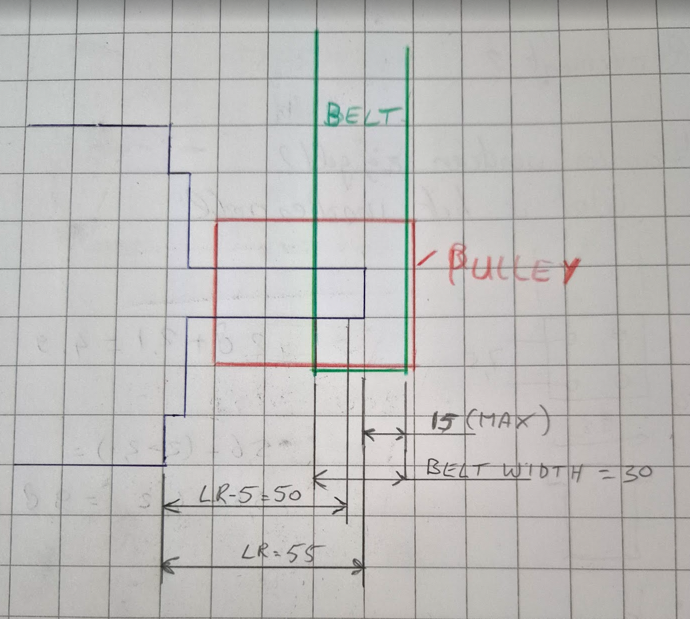

In [9]:
val smallPulley = TimingBeltPulley(8.mm.length, 18, 30.mm.length)
val largePulley = TimingBeltPulley(8.mm.length, 72, 30.mm.length)

val timingBeltPulleysCenterDistance = 165.5.mm.length
val timingBeltWidth = 30.mm.length
val timingBeltLength = 720.mm.length

val calculatedTimingBeltLength = timingBeltLength(
    timingBeltPulleysCenterDistance, smallPulley, largePulley
)

calculatedTimingBeltLength.inMillimeters

719.9972814648861

In [10]:
data class ServoMotor(
    val name: String,
    val ratedPower: Power,
    val ratedTorque: Torque,
    val maximumTorque: Torque,
    val ratedSpeed: AngularVelocity,
    val maximumSpeed: AngularVelocity,
    val ratedCurrent: Ampere,
    val maximumCurrent: Ampere,
    val maxRadialLoad: Force,
    val voltageClass: Voltage? = null,
    val brakeHoldingTorque: Torque? = null,
){
    val torqueConstantNmPerArms: Double get() = ratedTorque.inNm / ratedCurrent.inArms
}

val delta_ECM_B3M_E_1310 = ServoMotor(
    name = "Delta ECM-B3M-E...1310",
    ratedPower = 1.kW,
    ratedTorque = 4.77.Nm,
    maximumTorque = 14.3.Nm,
    ratedSpeed = 2000.rpm,
    maximumSpeed = 3000.rpm,
    ratedCurrent = 5.96.arms,
    maximumCurrent = 19.9.arms,
    maxRadialLoad = 490.N,
)

val delta_ECM_B3M_E_1315 = ServoMotor(
    name = "Delta ECM-B3M-E...1315",
    ratedPower = 1.5.kW,
    ratedTorque = 7.16.Nm,
    maximumTorque = 21.48.Nm,
    ratedSpeed = 2000.rpm,
    maximumSpeed = 3000.rpm,
    ratedCurrent = 8.17.arms,
    maximumCurrent = 26.82.arms,
    maxRadialLoad = 686.N,
)



In [11]:
@JvmInline
value class Angle private constructor(private val radians: Double) {
    val inDegrees get() = radians * 180.0 / Math.PI
    val inRadians get() = radians

    companion object {
        fun ofDegrees(v: Double) = Angle(v * Math.PI / 180.0)
        fun ofRadians(v: Double) = Angle(v)
    }

    override fun toString(): String {
        return "%.2f radians".format(inRadians)
    }

    fun toDegreesString(): String {
        return "%.2f degrees".format(inDegrees)
    }
}

val Double.radians get() = Angle.ofRadians(this)

fun sqrt(force: Force) = kotlin.math.sqrt(force.newton).N

In [13]:
fun radialLoadFeasability(
    selectedMotor: ServoMotor, maximumTorque: Torque
) {
    val deltaF = (maximumTorque.inNm / smallPulley.pitchDiameter.toRadius().meters).N

    // A timing belt doesn't have pretension
    val Fp = 0.N
    val T1 = Fp + deltaF / 2.0
    val T2 = Fp - deltaF / 2.0

    val Dl = largePulley.pitchDiameter.meters
    val Ds = smallPulley.pitchDiameter.meters
    val C = timingBeltPulleysCenterDistance.inMeters

    val x = ((Dl - Ds) / (2.0 * C)).coerceIn(-1.0, 1.0)
    val wrapAngleSmall = (Math.PI - 2.0 * kotlin.math.asin(x)).radians
    val theta = (PI - wrapAngleSmall.inRadians).radians

    val Fr = sqrt((T1.pow(2) + T2.pow(2) - 2 * T1 * T2 * cos(theta.inRadians)))

    val forceAtLrMin5 = Fr / 50.0 * 55.0

    DISPLAY(
        "Radial force on motor \"${selectedMotor.name}\" shaft: " +
                "$forceAtLrMin5 (calculated) vs ${selectedMotor.maxRadialLoad} @ LR-5 (allowable)"
    )
    DISPLAY("Result: ${if (forceAtLrMin5 <= selectedMotor.maxRadialLoad) "OK – shaft load within spec" else "NOT OK – exceeds shaft limit"}")
}

radialLoadFeasability(delta_ECM_B3M_E_1310, delta_ECM_B3M_E_1310.maximumTorque)
radialLoadFeasability(delta_ECM_B3M_E_1315, delta_ECM_B3M_E_1315.maximumTorque)
radialLoadFeasability(delta_ECM_B3M_E_1310, totalYAxisTorque)
radialLoadFeasability(delta_ECM_B3M_E_1315, totalYAxisTorque)

Radial force on motor "Delta ECM-B3M-E...1310" shaft: 624,32 N (calculated) vs 490,00 N @ LR-5 (allowable)

Result: NOT OK – exceeds shaft limit

Radial force on motor "Delta ECM-B3M-E...1315" shaft: 937,79 N (calculated) vs 686,00 N @ LR-5 (allowable)

Result: NOT OK – exceeds shaft limit

Radial force on motor "Delta ECM-B3M-E...1310" shaft: 254,49 N (calculated) vs 490,00 N @ LR-5 (allowable)

Result: OK – shaft load within spec

Radial force on motor "Delta ECM-B3M-E...1315" shaft: 254,49 N (calculated) vs 686,00 N @ LR-5 (allowable)

Result: OK – shaft load within spec